In [70]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
import sys
sys.path.append("/workspaces/twoohfoureight/src")

In [72]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import Counter
from IPython import display
import time

In [73]:
import ipywidgets as widgets

In [74]:
import game.rules as rules
from game.rules import (UP, LEFT, DOWN, RIGHT)
import game.multi as multi
import game.strategies as strategies

## Baseline random strategies

First, we'll try some random strategies to get a baseline for performance on the 2048 game.  It's typically a good strategy in 2048 to 'break symmetry', and as much as possible, make moves that favour moving towards one corner.  These strategies favour moving DOWN and LEFT, and we play 100 games to completion (i.e. until there are no valid remaining moves) with each.

In [76]:
choice_strategies = [
    [DOWN, LEFT] * 30 + [RIGHT]*1 + [UP],
    [DOWN, LEFT] * 30 + [RIGHT]*3 + [UP],    
    [DOWN, LEFT] * 30 + [RIGHT]*10 + [UP],
    [DOWN, LEFT] * 30 + [RIGHT]*30 + [UP],
]

n_games = 500
progress_bar = widgets.FloatProgress(max=n_games)
def update_progress_bar(n_game): progress_bar.value = n_game+1

display.display(progress_bar)
    
result = [
    rules.play_to_completion(strategies.random_strategy(vec), n_games, progress_callback=update_progress_bar)
    for vec in choice_strategies
]

FloatProgress(value=0.0, max=500.0)

The following histograms show the distribution of the highest scoring cell across the 500 games for each strategy. The best performing strategy appears to be the first, with DOWN and LEFT moves outnumbering RIGHT and UP moves by 30 to 1, but there's not much in it. None of these baseline strategies are able to get a $2^{10} =  1024$ cell.

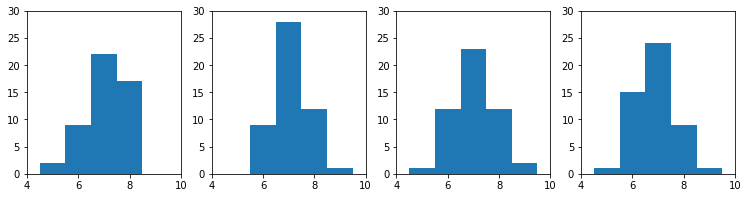

In [7]:
plt.figure(figsize=(16,3))
for ind, x in enumerate(result):
    plt.subplot(151+ind, xlim=(4,10), ylim=(0,30))
    plt.hist([score for mvs, score in x], bins=[0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5])
plt.show()

In the interest of speeding up the evaluation of a strategy, the `game.multi` package takes advantage of numpy vectorisation to play multiple games 'at once'. The 'multi' game state with $n$ games is represented by an $n \times 4 \times 4$ numpy array.

In [8]:
def random_strategy_multi(choices):
    def strategy(state):
        return np.random.choice(choices, size=state.shape[0])
    return strategy

In [10]:
n_games = 2000
progress_bar = widgets.FloatProgress(max=n_games)

def update_progress_bar(n_complete): progress_bar.value = n_complete+1

display(progress_bar)

move_counts, complete, final_states = multi.play_to_completion(
    random_strategy_multi(choice_strategies[0]), n_games, max_turns=10000,
    progress_callback=update_progress_bar
)

FloatProgress(value=0.0, max=2000.0)

all games complete after 1790 turns


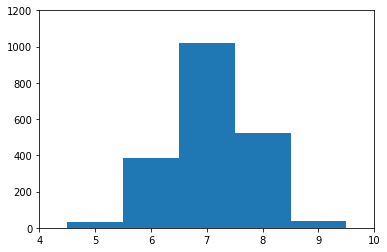

In [11]:
plt.subplot(111, xlim=(4,10), ylim=(0,1200))
plt.hist(np.max(final_states.reshape(2000, -1), axis=1), bins=[0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5])
plt.show()

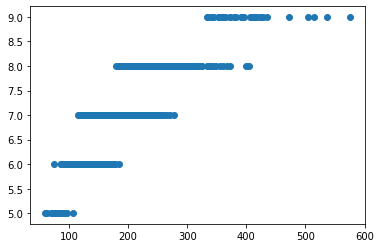

In [12]:
plt.scatter(move_counts, np.max(final_states.reshape(2000, -1), axis=1))

## Trying to do better with reinforcement learning

In [14]:
import tensorflow as tf
from operator import itemgetter

We'll use a very simple 2 layer network to start with:

- one-hot encoding for the game board
- feeding into a $4 \times 4 \times 48$ convolutional layer, with $3 \times 3$ kernel and relu activation
- feeding into a $96$ unit dense layer, also relu
- feeding into a $4$ unit output layer, where each output unit represents one of the possible moves (UP, LEFT, DOWN, RIGHT)

In [57]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(48, (2, 2), padding="valid", activation="relu", input_shape=(4,4,12)),
#     tf.keras.layers.Conv2D(48, (3, 3), padding="valid", activation="relu"),    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(96, activation="relu"),
    tf.keras.layers.Dense(4, activation="relu")
])
sgd = tf.keras.optimizers.SGD(lr=1e-4)
model.compile(loss="mse", optimizer=sgd)

Some helper functions to make moves based on expected reward ($Q$)

In [ ]:
def init_state():
    return np.array([
        [1,0,0,0],
        [0,0,0,0],
        [0,0,0,0],
        [0,0,0,0],
    ])

def state_to_nn_input(s):
    return np.eye(12)[s].reshape([1, 4, 4, 12])

move_names = [UP, LEFT, DOWN, RIGHT];

def select_move(state, Q):
    allowed_moves = np.array([np.any(state != rules.next_state(state, move)) for move in move_names])
    return np.arange(0, 4)[allowed_moves][np.argmax(Q[allowed_moves])]

def random_action(s):
    return select_move(s, np.random.rand(4))

Update state, and return the reward for the action (along with whether the action was successful, and whether the game is over)

In [60]:
def next_step(state, action):
    new_state = rules.next_state(state, move_names[action])
    if np.all(new_state == state):
        reward = 0
        return new_state, reward, False, True
    else:
        new_state = rules.perturb(new_state)
        if np.random.rand(1) < 0.1:
            new_state = rules.rotCW(new_state)
    
    if rules.is_done(new_state):
        reward = np.sum(3.0 ** new_state)
        return new_state, reward, True, False
    else:
        reward = 0.1 * np.sum(new_state == 0)
        return new_state, reward, False, False

Play lots of games; try to train a model!

[[2 1 2 3]
 [4 5 3 2]
 [2 7 9 5]
 [1 4 3 1]]
0.004950985246063967


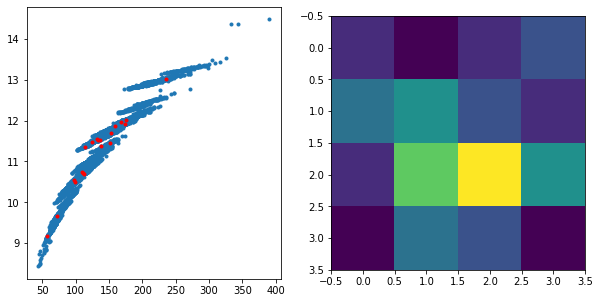

In [68]:
e = 0.5 # ε for ε-greedy policy
y = 0.99 # Temporal discount factor
num_episodes = 10000
j_list = [] # Number of turns per game
r_list = [] # final total score per game
top_scoring_S = None # Final state in current top-scoring game
top_score = 0.0 # current best score
move_indices = { name: ind for ind, name in enumerate(move_names)}
for episode in range(num_episodes):
    s = init_state()
    r_all = 0
    done = False
    move = 0
    actions = []
    while move < 2000:
        move += 1
        # Get the model estimate of the expected reward based on the current state
        R_current = model.predict(state_to_nn_input(s))[0]
        
        # Use an ε-greedy policy for action selection
        if np.random.rand(1) < e:
            a = random_action(s)
        else:
            a = select_move(s, R_current)
        s1,r,done,no_move = next_step(s, a)
        
        # Update the model
        R_new = model.predict(state_to_nn_input(s1))[0]
        target = r + y * np.max(R_new)
        R_target = np.array(R_current)
        R_target[a] = target
        model.fit(state_to_nn_input(s), R_target.reshape(-1, 4), epochs=1, verbose=0)
        
        # Remember the actions taken
        actions.append("x" if no_move else move_names[a])
        r_all += r
#         if (episode+1) % 10 == 0:
#             display.clear_output(wait=True)
#             print("{}".format(actions[-1]))
#             print(s)
#             print(r, r_all)
#             time.sleep(0.2)
        s = s1
    
        # Reduce e
        if done == True:
            if r_all > 500:
                e = 1./((episode/50) + 2)
            break
    if r_all > top_score:
        top_scoring_s = s
        top_score = r_all
    print(f"Episode {episode} of {num_episodes}: {r_all}, {move}{' '*100}", end='\r')
    j_list.append(move)
    r_list.append(r_all)
    if (episode+1) % 50 == 0:
        display.clear_output(wait=True)
        plt.figure(figsize=(10,5))
        plt.subplot(121)
        plt.plot(j_list, [np.log2(r) for r in r_list], '.')
        plt.plot(j_list[-20:], [np.log2(r) for r in r_list[-20:]], 'r.')          
        plt.subplot(122)
        print(top_scoring_s)
        print(e)
        plt.imshow(top_scoring_s)
        plt.show()